Visualizing the 3D geometry of the X-ray detector in `DiffDRR` can be a helpful sanity check and is useful for debugging. We enable visualization of the `DiffDRR` set up using `PyVista`. The dependencies are `pyvista`, `trame`, and `vtk`.

The 3D visualization functions in `DiffDRR` perform the following:
- Extract a mesh from your CT volume
- Plot a pyramid frustum to visualize the camera pose
- Plot the detector plane with the DRR embedded as a texture
- Draw the principal ray from the X-ray source to the detector plane

Mesh extraction currently supports
- MarchingCubes
- [SurfaceNets](https://www.kitware.com/really-fast-isocontouring/)

In the future, we plan to merge [SurfaceNets](https://www.kitware.com/really-fast-isocontouring/) with [TotalSegmentator](https://github.com/wasserth/TotalSegmentator) such that CT meshes can be rendered from label maps.

In [ ]:
import pyvista

pyvista.set_jupyter_backend("trame")

In [ ]:
#| code-fold: true
import torch

from diffdrr.data import load_example_ct
from diffdrr.drr import DRR
from diffdrr.visualization import drr_to_mesh, img_to_mesh

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Read in the volume and get the isocenter
volume, spacing = load_example_ct()
bx, by, bz = torch.tensor(volume.shape) * torch.tensor(spacing) / 2
focal_len = 1020.0

# Initialize the DRR module for generating synthetic X-rays
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drr = DRR(
    volume,  # The CT volume as a numpy array
    spacing,  # Voxel dimensions of the CT
    sdr=focal_len
    / 2,  # Source-to-detector radius (half of the source-to-detector distance)
    height=200,  # Height of the DRR (if width is not seperately provided, the generated image is square)
    delx=2.0,  # Pixel spacing (in mm)
).to(device)

2023-11-25 13:32:18.702 (   2.753s) [          3536E5]   vtkSurfaceNets3D.cxx:2322  INFO| Executing Surface Nets 3D
2023-11-25 13:32:18.828 (   2.879s) [          3536E5]   vtkSurfaceNets3D.cxx:2396  INFO| Extracted: 727607 points, 740955 quads
2023-11-25 13:32:18.829 (   2.880s) [          3536E5]   vtkSurfaceNets3D.cxx:1816  INFO| Smoothing output
2023-11-25 13:32:18.829 (   2.880s) [          3536E5]vtkConstrainedSmoothing:448   INFO| Executing constrained smoothing filter


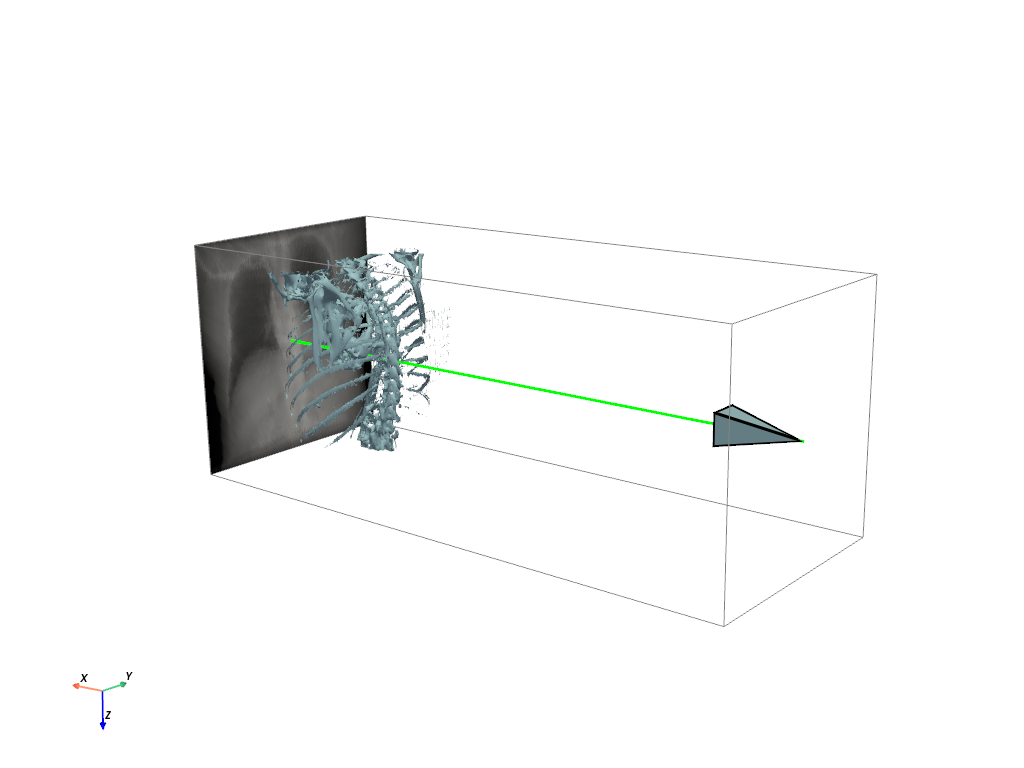

In [ ]:
plotter = pyvista.Plotter()

# Make a mesh from the CT volume
ct = drr_to_mesh(drr, "surface_nets", threshold=1400, verbose=False)
plotter.add_mesh(ct)

# Make a mesh from the camera and detector plane
rotations = torch.tensor([[torch.pi, 0.0, torch.pi / 2]], device=device)
translations = torch.tensor([[bx - focal_len / 3, by, bz]], device=device)
camera, detector, texture, principal_ray = img_to_mesh(
    drr, rotations, translations, "euler_angles", "ZYX"
)
plotter.add_mesh(camera, show_edges=True, line_width=3)
plotter.add_mesh(principal_ray, color="lime", line_width=3)
plotter.add_mesh(detector, texture=texture)

# Make the plot
cpos = [
    (-1540.117981442732, -1500.1627121239017, -414.6949300747409),
    (-159.99998474121094, 180.0000457763672, 166.24999237060547),
    (0.15291844150431175, 0.20840566086601953, -0.9660139909788523),
]
plotter.add_axes()
plotter.add_bounding_box()
plotter.show(cpos=cpos, jupyter_backend="html")